<a href="https://colab.research.google.com/github/jingjieyeo/pytorch_linear_regression/blob/main/gcam_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
Multiple linear regression serves as a crucial benchmark for complex models, allowing researchers to establish baseline performance before building sophisticated neural networks or ensemble models, while its interpretability enables clear communication to policymakers about how GDP affects energy consumption. Understanding these regression-based relationships is essential for critically using integrated assessment models like GCAM, which employ similar approaches for some sectors.

This exercise demonstrates core data science workflows: exploratory data analysis, train-test splits, and evaluation metrics using authentic climate-energy data. Machine learning concepts are introduced through a concrete application with direct policy relevance.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("=" * 70)
print("MULTIPLE LINEAR REGRESSION WITH PYTORCH")
print("GDP + POPULATION → BUILDING ENERGY CONSUMPTION")
print("=" * 70)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


MULTIPLE LINEAR REGRESSION WITH PYTORCH
GDP + POPULATION → BUILDING ENERGY CONSUMPTION

Using device: cpu


In [ ]:
# ============================================================================
# STEP 1: LOAD AND EXPLORE THE GCAM DATA
# ============================================================================
print("\n" + "=" * 70)
print("STEP 1: DATA LOADING AND EXPLORATION")
print("=" * 70)

# Load the GCAM CSV file
df = pd.read_csv('/content/drive/MyDrive/station1/gcam_ml/dataset.csv')

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nColumn names and types:")
print(df.dtypes)

print(f"\nBasic statistics:")
print(df.describe())

print(f"\nRegions in dataset: {df['region'].unique()}")
print(f"Years covered: {sorted(df['year'].unique())}")
print(f"Total observations: {len(df)}")

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())



STEP 1: DATA LOADING AND EXPLORATION

Dataset loaded successfully!
Shape: (15, 5)

First few rows:
  region  year  population      gdp  building_energy
0    usa  1990      251728  22.5870        15.919570
1    usa  2005      300755  30.0655        19.895417
2    usa  2010      315007  30.1214        20.034440
3    usa  2015      328208  32.3356        19.442739
4    usa  2021      340354  34.4662        19.758402

Column names and types:
region              object
year                 int64
population           int64
gdp                float64
building_energy    float64
dtype: object

Basic statistics:
              year    population        gdp  building_energy
count    15.000000  1.500000e+01  15.000000        15.000000
mean   2008.200000  6.771989e+05  19.324361        16.684249
std      10.903473  4.849873e+05  11.135858         2.909828
min    1990.000000  2.517280e+05   0.926142        12.758856
25%    2005.000000  3.342810e+05   8.871210        14.313956
50%    2010.000000  3.9

In [ ]:
# ============================================================================
# STEP 2: DATA PREPROCESSING
# ============================================================================
print("\n" + "=" * 70)
print("STEP 2: DATA PREPROCESSING")
print("=" * 70)

# Create features and target
# Features: GDP and Population
# Target: Building Energy Consumption
X = df[['gdp', 'population']].values
y = df['building_energy'].values

print(f"\nFeature Matrix (X) shape: {X.shape}")
print(f"Target Vector (y) shape: {y.shape}")

print(f"\nFeatures:")
print(f"  1. GDP (in units from GCAM)")
print(f"  2. Population (in thousands)")
print(f"\nTarget:")
print(f"  Building Energy Consumption (EJ)")

# Split data temporally (training: 1990-2010, testing: 2015-2021)
train_mask = df['year'] <= 2010
test_mask = df['year'] > 2010

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"\n--- Temporal Train-Test Split ---")
print(f"Training period: 1990-2010")
print(f"Testing period: 2015-2021")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Feature scaling (important for neural networks)
print("\n--- Feature Standardization ---")
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Also scale target for better training (will inverse transform for evaluation)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"✓ Features standardized (mean=0, std=1)")
print(f"  Training set - GDP mean: {X_train_scaled[:, 0].mean():.4f}, std: {X_train_scaled[:, 0].std():.4f}")
print(f"  Training set - Pop mean: {X_train_scaled[:, 1].mean():.4f}, std: {X_train_scaled[:, 1].std():.4f}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

print(f"\n✓ Data converted to PyTorch tensors")
print(f"  Training tensors on: {X_train_tensor.device}")


STEP 2: DATA PREPROCESSING

Feature Matrix (X) shape: (15, 2)
Target Vector (y) shape: (15,)

Features:
  1. GDP (in units from GCAM)
  2. Population (in thousands)

Target:
  Building Energy Consumption (EJ)

--- Temporal Train-Test Split ---
Training period: 1990-2010
Testing period: 2015-2021
Training samples: 9 (60.0%)
Testing samples: 6 (40.0%)

--- Feature Standardization ---
✓ Features standardized (mean=0, std=1)
  Training set - GDP mean: 0.0000, std: 1.0000
  Training set - Pop mean: -0.0000, std: 1.0000

✓ Data converted to PyTorch tensors
  Training tensors on: cpu


In [ ]:
# ============================================================================
# STEP 3: DEFINE PYTORCH MODEL
# ============================================================================
print("\n" + "=" * 70)
print("STEP 3: MODEL ARCHITECTURE")
print("=" * 70)

class MultipleLinearRegression(nn.Module):
    """
    PyTorch model for multiple linear regression.

    This is equivalent to: y = β₀ + β₁*GDP + β₂*Population

    Architecture:
    - Input layer: 2 features (GDP, Population)
    - Output layer: 1 output (Building Energy)
    - No hidden layers (pure linear regression)
    """

    def __init__(self, input_dim, output_dim):
        super(MultipleLinearRegression, self).__init__()
        # Linear transformation: y = Wx + b
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """Forward pass through the network"""
        return self.linear(x)

# Instantiate the model
input_dim = 2  # GDP and Population
output_dim = 1  # Building Energy

model = MultipleLinearRegression(input_dim, output_dim).to(device)

print(f"\nModel Architecture:")
print(model)

print(f"\nModel Parameters:")
for name, param in model.named_parameters():
    print(f"  {name}: shape {param.shape}, requires_grad={param.requires_grad}")

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal trainable parameters: {total_params}")


STEP 3: MODEL ARCHITECTURE

Model Architecture:
MultipleLinearRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

Model Parameters:
  linear.weight: shape torch.Size([1, 2]), requires_grad=True
  linear.bias: shape torch.Size([1]), requires_grad=True

Total trainable parameters: 3


In [ ]:
# ============================================================================
# STEP 4: DEFINE LOSS FUNCTION AND OPTIMIZER
# ============================================================================
print("\n" + "=" * 70)
print("STEP 4: TRAINING CONFIGURATION")
print("=" * 70)

# Loss function: Mean Squared Error (MSE)
criterion = nn.MSELoss()

# Optimizer: Stochastic Gradient Descent (SGD) or Adam
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# Alternative: optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"\nLoss Function: Mean Squared Error (MSE)")
print(f"Optimizer: Stochastic Gradient Descent")
print(f"  Learning rate: {learning_rate}")
print(f"  Momentum: 0.9")



STEP 4: TRAINING CONFIGURATION

Loss Function: Mean Squared Error (MSE)
Optimizer: Stochastic Gradient Descent
  Learning rate: 0.01
  Momentum: 0.9


In [ ]:
# ============================================================================
# STEP 5: TRAIN THE MODEL
# ============================================================================
print("\n" + "=" * 70)
print("STEP 5: MODEL TRAINING")
print("=" * 70)

num_epochs = 500
print_every = 50

# Lists to store training history
train_losses = []
test_losses = []

print(f"\nTraining for {num_epochs} epochs...")
print(f"Progress updates every {print_every} epochs\n")

# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()

    # Forward pass
    y_pred_train = model(X_train_tensor).squeeze()

    # Compute loss
    loss = criterion(y_pred_train, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()         # Compute gradients
    optimizer.step()        # Update weights

    # Store training loss
    train_losses.append(loss.item())

    # Evaluate on test set (no gradient computation needed)
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor).squeeze()
        test_loss = criterion(y_pred_test, y_test_tensor)
        test_losses.append(test_loss.item())

    # Print progress
    if (epoch + 1) % print_every == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {loss.item():.6f}, "
              f"Test Loss: {test_loss.item():.6f}")

print(f"\n✓ Training complete!")
print(f"  Final training loss: {train_losses[-1]:.6f}")
print(f"  Final test loss: {test_losses[-1]:.6f}")


STEP 5: MODEL TRAINING

Training for 500 epochs...
Progress updates every 50 epochs

Epoch [50/500] - Train Loss: 0.214747, Test Loss: 1.390274
Epoch [100/500] - Train Loss: 0.149794, Test Loss: 1.088693
Epoch [150/500] - Train Loss: 0.137892, Test Loss: 1.052195
Epoch [200/500] - Train Loss: 0.135659, Test Loss: 1.044026
Epoch [250/500] - Train Loss: 0.135240, Test Loss: 1.042521
Epoch [300/500] - Train Loss: 0.135161, Test Loss: 1.042224
Epoch [350/500] - Train Loss: 0.135146, Test Loss: 1.042163
Epoch [400/500] - Train Loss: 0.135144, Test Loss: 1.042149
Epoch [450/500] - Train Loss: 0.135143, Test Loss: 1.042146
Epoch [500/500] - Train Loss: 0.135143, Test Loss: 1.042143

✓ Training complete!
  Final training loss: 0.135143
  Final test loss: 1.042143


In [ ]:
# ============================================================================
# STEP 6: EXTRACT LEARNED PARAMETERS
# ============================================================================
print("\n" + "=" * 70)
print("STEP 6: LEARNED MODEL PARAMETERS")
print("=" * 70)

# Extract weights and bias
model.eval()
with torch.no_grad():
    weights = model.linear.weight.cpu().numpy()[0]
    bias = model.linear.bias.cpu().numpy()[0]

print(f"\nStandardized Model Parameters:")
print(f"  Weight for GDP (β₁):        {weights[0]:.6f}")
print(f"  Weight for Population (β₂): {weights[1]:.6f}")
print(f"  Bias (β₀):                  {bias:.6f}")

print(f"\nStandardized Equation:")
print(f"  Energy_scaled = {bias:.4f} + {weights[0]:.4f}×GDP_scaled + {weights[1]:.4f}×Pop_scaled")

# Feature importance (absolute standardized coefficients)
print(f"\n--- Feature Importance (Standardized) ---")
feature_importance = pd.DataFrame({
    'Feature': ['GDP', 'Population'],
    'Coefficient': weights,
    'Abs_Coefficient': np.abs(weights)
}).sort_values('Abs_Coefficient', ascending=False)

print(feature_importance)

if abs(weights[0]) > abs(weights[1]):
    print(f"\n✓ GDP has stronger influence (ratio: {abs(weights[0])/abs(weights[1]):.2f}:1)")
else:
    print(f"\n✓ Population has stronger influence (ratio: {abs(weights[1])/abs(weights[0]):.2f}:1)")


STEP 6: LEARNED MODEL PARAMETERS

Standardized Model Parameters:
  Weight for GDP (β₁):        2.238972
  Weight for Population (β₂): 1.652332
  Bias (β₀):                  -0.000000

Standardized Equation:
  Energy_scaled = -0.0000 + 2.2390×GDP_scaled + 1.6523×Pop_scaled

--- Feature Importance (Standardized) ---
      Feature  Coefficient  Abs_Coefficient
0         GDP     2.238972         2.238972
1  Population     1.652332         1.652332

✓ GDP has stronger influence (ratio: 1.36:1)


In [ ]:
# ============================================================================
# STEP 7: MODEL EVALUATION
# ============================================================================
print("\n" + "=" * 70)
print("STEP 7: MODEL EVALUATION")
print("=" * 70)

# Make predictions on both sets
model.eval()
with torch.no_grad():
    y_train_pred_scaled = model(X_train_tensor).squeeze().cpu().numpy()
    y_test_pred_scaled = model(X_test_tensor).squeeze().cpu().numpy()

# Inverse transform predictions back to original scale
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n--- Training Set Performance ---")
print(f"  RMSE: {train_rmse:.4f} EJ")
print(f"  MAE:  {train_mae:.4f} EJ")
print(f"  R²:   {train_r2:.4f}")

print("\n--- Testing Set Performance ---")
print(f"  RMSE: {test_rmse:.4f} EJ")
print(f"  MAE:  {test_mae:.4f} EJ")
print(f"  R²:   {test_r2:.4f}")

print(f"\nModel Explanation:")
print(f"  The model explains {test_r2*100:.2f}% of the variance in")
print(f"  building energy consumption on the test set.")


STEP 7: MODEL EVALUATION

--- Training Set Performance ---
  RMSE: 0.8736 EJ
  MAE:  0.8084 EJ
  R²:   0.8649

--- Testing Set Performance ---
  RMSE: 2.4260 EJ
  MAE:  2.1354 EJ
  R²:   0.3538

Model Explanation:
  The model explains 35.38% of the variance in
  building energy consumption on the test set.



STEP 8: VISUALIZATION


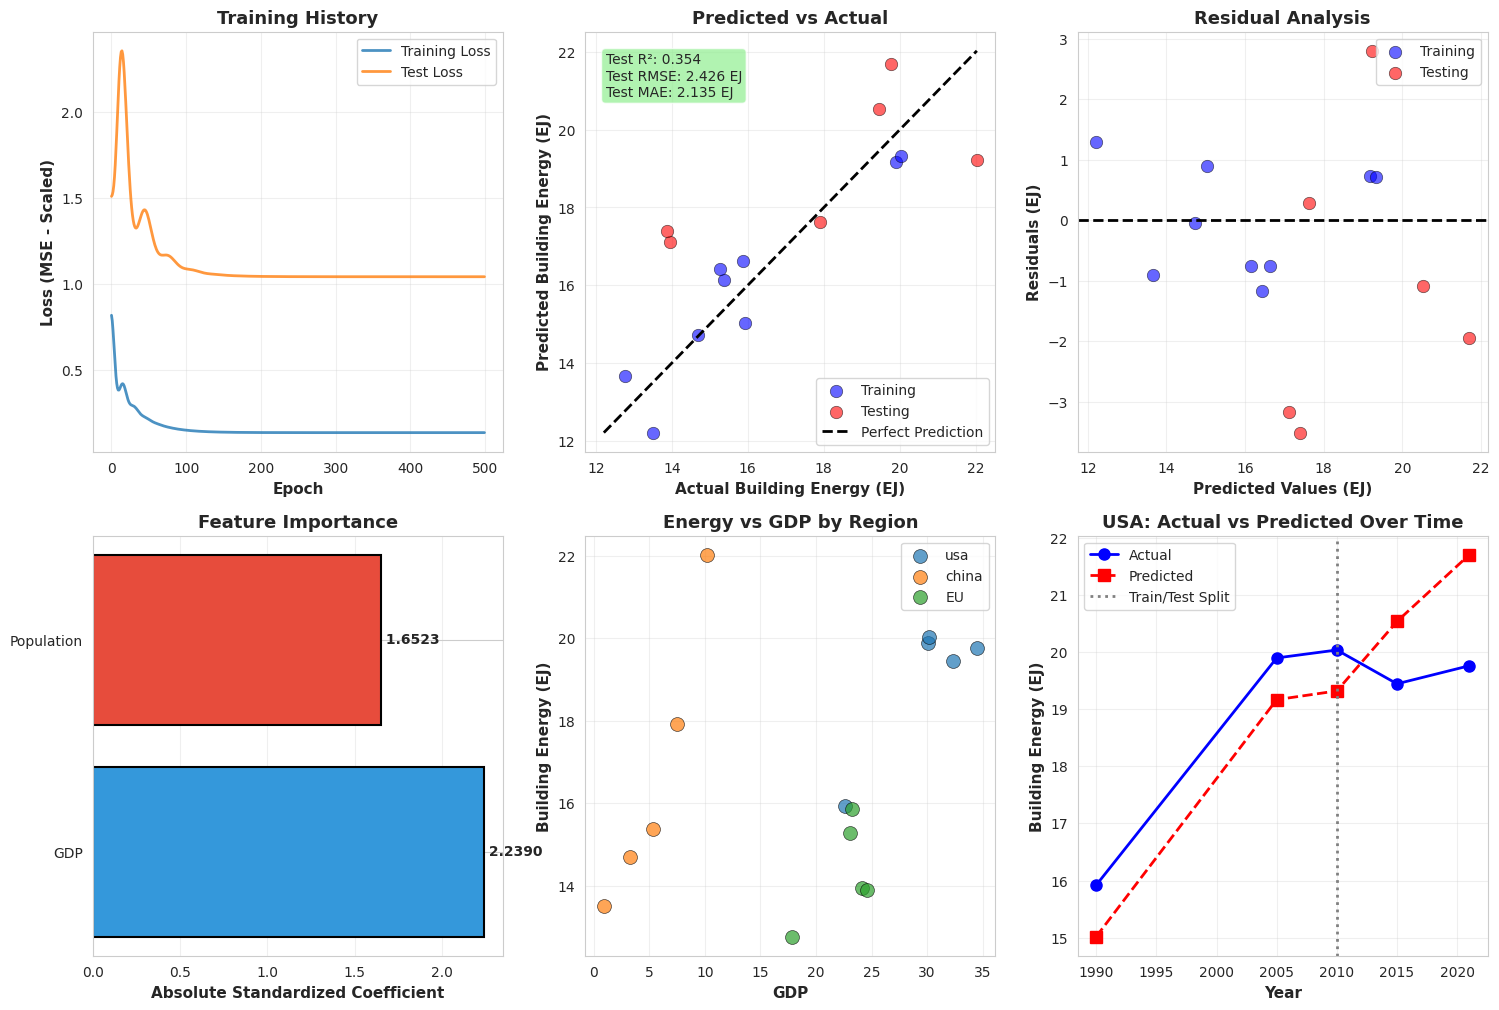

In [ ]:
# ============================================================================
# STEP 8: VISUALIZATION
# ============================================================================
print("\n" + "=" * 70)
print("STEP 8: VISUALIZATION")
print("=" * 70)

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))

# Plot 1: Training Loss Curve
ax1 = plt.subplot(2, 3, 1)
ax1.plot(train_losses, label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(test_losses, label='Test Loss', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss (MSE - Scaled)', fontsize=11, fontweight='bold')
ax1.set_title('Training History', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Predicted vs Actual
ax2 = plt.subplot(2, 3, 2)
ax2.scatter(y_train, y_train_pred, alpha=0.6, s=80, c='blue',
           label='Training', edgecolors='k', linewidth=0.5)
ax2.scatter(y_test, y_test_pred, alpha=0.6, s=80, c='red',
           label='Testing', edgecolors='k', linewidth=0.5)

# Perfect prediction line
min_val = min(y_train.min(), y_test.min(), y_train_pred.min(), y_test_pred.min())
max_val = max(y_train.max(), y_test.max(), y_train_pred.max(), y_test_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')

ax2.set_xlabel('Actual Building Energy (EJ)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Predicted Building Energy (EJ)', fontsize=11, fontweight='bold')
ax2.set_title('Predicted vs Actual', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Add metrics text
metrics_text = f'Test R²: {test_r2:.3f}\nTest RMSE: {test_rmse:.3f} EJ\nTest MAE: {test_mae:.3f} EJ'
ax2.text(0.05, 0.95, metrics_text, transform=ax2.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# Plot 3: Residual Plot
ax3 = plt.subplot(2, 3, 3)
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

ax3.scatter(y_train_pred, train_residuals, alpha=0.6, s=80, c='blue',
           label='Training', edgecolors='k', linewidth=0.5)
ax3.scatter(y_test_pred, test_residuals, alpha=0.6, s=80, c='red',
           label='Testing', edgecolors='k', linewidth=0.5)
ax3.axhline(y=0, color='k', linestyle='--', linewidth=2)
ax3.set_xlabel('Predicted Values (EJ)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Residuals (EJ)', fontsize=11, fontweight='bold')
ax3.set_title('Residual Analysis', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Feature Importance Bar Chart
ax4 = plt.subplot(2, 3, 4)
features = ['GDP', 'Population']
abs_coeffs = np.abs(weights)
colors = ['#3498db', '#e74c3c']

bars = ax4.barh(features, abs_coeffs, color=colors, edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Absolute Standardized Coefficient', fontsize=11, fontweight='bold')
ax4.set_title('Feature Importance', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, coef) in enumerate(zip(bars, abs_coeffs)):
    ax4.text(coef, i, f' {coef:.4f}', va='center', fontsize=10, fontweight='bold')

# Plot 5: Energy vs GDP (colored by region)
ax5 = plt.subplot(2, 3, 5)
for region in df['region'].unique():
    region_data = df[df['region'] == region]
    ax5.scatter(region_data['gdp'], region_data['building_energy'],
               label=region, alpha=0.7, s=100, edgecolors='k', linewidth=0.5)

ax5.set_xlabel('GDP', fontsize=11, fontweight='bold')
ax5.set_ylabel('Building Energy (EJ)', fontsize=11, fontweight='bold')
ax5.set_title('Energy vs GDP by Region', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# Plot 6: Time series comparison for one region
ax6 = plt.subplot(2, 3, 6)

# Combine all data with predictions
all_data = df.copy()
all_predictions_full = np.zeros(len(df))

# Fill in predictions at the correct positions
train_positions = np.where(train_mask)[0]
test_positions = np.where(test_mask)[0]

all_predictions_full[train_positions] = y_train_pred
all_predictions_full[test_positions] = y_test_pred

all_data['predictions'] = all_predictions_full

# Filter for USA and plot
usa_data = all_data[all_data['region'] == 'usa'].sort_values('year')

ax6.plot(usa_data['year'], usa_data['building_energy'], 'o-', linewidth=2, markersize=8,
         label='Actual', color='blue')
ax6.plot(usa_data['year'], usa_data['predictions'], 's--', linewidth=2, markersize=8,
         label='Predicted', color='red')
ax6.axvline(x=2010, color='gray', linestyle=':', linewidth=2, label='Train/Test Split')
ax6.set_xlabel('Year', fontsize=11, fontweight='bold')
ax6.set_ylabel('Building Energy (EJ)', fontsize=11, fontweight='bold')
ax6.set_title('USA: Actual vs Predicted Over Time', fontsize=13, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3)

In [ ]:
# ============================================================================
# STEP 9: MODEL COMPARISON TABLE
# ============================================================================
print("\n" + "=" * 70)
print("STEP 9: DETAILED PREDICTIONS BY REGION")
print("=" * 70)

# Create detailed results table
results_df = df.copy()
all_predictions = np.concatenate([y_train_pred, y_test_pred])
all_actual = np.concatenate([y_train, y_test])
all_indices = np.concatenate([np.where(train_mask)[0], np.where(test_mask)[0]])

# Create properly ordered predictions
full_predictions = np.zeros(len(df))
full_predictions[all_indices] = all_predictions

results_df['Predicted'] = full_predictions
results_df['Actual'] = y
results_df['Residual'] = results_df['Actual'] - results_df['Predicted']
results_df['Abs_Error'] = np.abs(results_df['Residual'])
results_df['Pct_Error'] = (results_df['Abs_Error'] / results_df['Actual']) * 100
results_df['Split'] = ['Train' if m else 'Test' for m in train_mask]

print("\nSample Predictions:")
print(results_df[['region', 'year', 'Actual', 'Predicted', 'Residual', 'Split']].to_string(index=False))

print("\n--- Performance by Region ---")
region_performance = results_df.groupby('region').agg({
    'Abs_Error': 'mean',
    'Pct_Error': 'mean',
    'Residual': lambda x: np.sqrt(np.mean(x**2))  # RMSE
}).round(4)
region_performance.columns = ['MAE', 'MAPE (%)', 'RMSE']
print(region_performance)


STEP 9: DETAILED PREDICTIONS BY REGION

Sample Predictions:
region  year    Actual  Predicted  Residual Split
   usa  1990 15.919570  15.018007  0.901563 Train
   usa  2005 19.895417  19.165503  0.729914 Train
   usa  2010 20.034440  19.318239  0.716201 Train
   usa  2015 19.442739  20.534685 -1.091946  Test
   usa  2021 19.758402  21.700321 -1.941919  Test
 china  1990 13.502038  12.211859  1.290180 Train
 china  2005 14.685360  14.724484 -0.039124 Train
 china  2010 15.376561  16.139517 -0.762956 Train
 china  2015 17.911486  17.621807  0.289679  Test
 china  2021 22.027320  19.225151  2.802169  Test
    EU  1990 12.758856  13.668860 -0.910004 Train
    EU  2005 15.262773  16.425303 -1.162529 Train
    EU  2010 15.864653  16.627897 -0.763244 Train
    EU  2015 13.942553  17.119274 -3.176722  Test
    EU  2021 13.881563  17.391741 -3.510178  Test

--- Performance by Region ---
           MAE  MAPE (%)    RMSE
region                          
EU      1.9045   13.5262  2.2439
china   1